# General form regression using DeepLearning

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from symreg.formula import *
from symreg.simplify import *
import torch.nn.functional as F

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: False 


## Normalization

In [3]:
X = np.linspace(0, 10, 1000)
Y = 3 * np.sin(0.5 * X * X) + X - 10

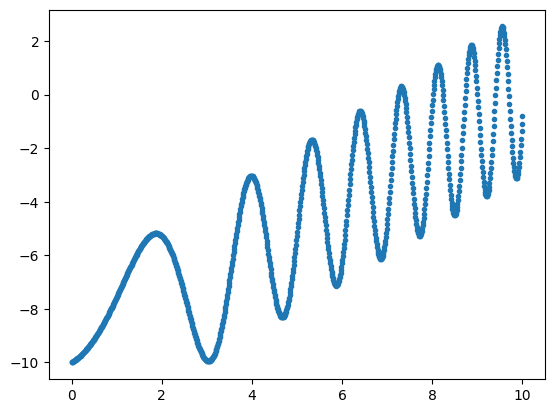

In [4]:
plt.scatter(X, Y, marker='.')
plt.show()

In [5]:
def normalize(X, Y, size: int = 100):
    """
    Min-max normalization.
    """

    x_min, x_max = np.min(X), np.max(X)
    y_min, y_max = np.min(Y), np.max(Y)

    idx = np.round(np.linspace(0, len(X) - 1, size)).astype(int)
    X_norm = ((X - x_min) / (x_max - x_min))[idx]
    Y_norm = ((Y - y_min) / (y_max - y_min))[idx]
    return X_norm, Y_norm

In [6]:
def normalize(X, Y, size: int = 100):
    """
    Z-score normalization (standardization).
    """

    idx = np.round(np.linspace(0, len(X) - 1, size)).astype(int)
    X_norm = X[idx]
    Y_norm = ((Y - np.mean(Y)) / np.std(Y))[idx]
    return X_norm, Y_norm

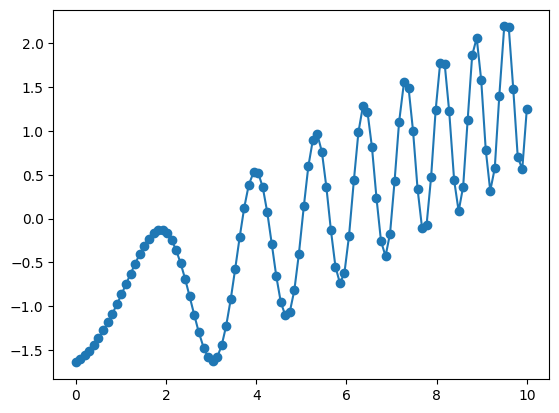

In [7]:
X_norm, Y_norm = normalize(X, Y)
plt.plot(X_norm, Y_norm)
plt.scatter(X_norm, Y_norm)
plt.show()

## Generating the dataset

In [8]:
from symreg.random import random_formula, RandomOptions

- Sinus, cosinus
- Tangent
- Divide, product
- Add, subtract
- Sqrt
- Log

```
  BINARY OPERATORS                   UNARY OPERATORS
 ADD/SUB | MUL/DIV   |   EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG
```

In [9]:
from symreg.formula import ExpressionVisitor, BinaryOp, UnaryOp

class VectorVisitor(ExpressionVisitor):
    def __init__(self):
        super().__init__()
        self.vector = np.zeros(9)

    def visit_binary_expr(self, expr):
        super().visit_binary_expr(expr)

        match expr.op:
            case BinaryOp.ADD | BinaryOp.SUB:
                self.vector[0] = 1
            case BinaryOp.MUL | BinaryOp.DIV:
                self.vector[1] = 1
            case _:
                raise NotImplementedError
    
    def visit_unary_expr(self, expr):
        super().visit_unary_expr(expr)

        match expr.op:
            case UnaryOp.EXP:
                self.vector[2] = 1
            case UnaryOp.SIN:
                self.vector[3] = 1
            case UnaryOp.TAN:
                self.vector[4] = 1
            case UnaryOp.ASIN:
                self.vector[5] = 1
            case UnaryOp.ATAN:
                self.vector[6] = 1
            case UnaryOp.SQRT:
                self.vector[7] = 1
            case UnaryOp.LOG:
                self.vector[8] = 1


def generate_formula_dataset(n: int, sample_count: int = 5, max_depth=3, x_range = (-10, 10)):
    X = np.linspace(x_range[0], x_range[1], sample_count)+1e-5

    options = RandomOptions()
    options.max_depth = max_depth
    options.definition_set = X
    print(options.allowed_unary_operators,options.allowed_unary_operators_probs)

    data = []
    labels = []

    i = 0
    while i < n:
        formula = random_formula(options)
        Y = formula(X)

        if isinstance(Y, float):
            Y = np.array([Y] * len(X))

        if np.any(np.isnan(Y)):
            continue

        eta = 1e-3 * 0
        Y += eta * np.random.normal(np.mean(Y), np.std(Y), np.shape(Y))

        X_norm, Y_norm = normalize(X, Y, sample_count)
        if np.any(np.isnan(Y_norm)):
            continue

        visitor = VectorVisitor()
        visitor.accept(formula.expr)
        data.append(np.array([X_norm,Y_norm]).T)
        labels.append(visitor.vector)
        i += 1

        if i % 500 == 0:
            print(f"Generated [{i}]")

        if n<=5:

            print(formula)
            plt.plot(X_norm,Y_norm)
            plt.show()

    data = np.array(data)
    labels = np.array(labels)

    data = torch.tensor(data, dtype=torch.float32)
    labels = torch.tensor(labels[:,2:], dtype=torch.float32)

    print(data.shape)
    print(labels.shape)

    return data, labels


[<UnaryOp.EXP: <ufunc 'exp'>>, <UnaryOp.SIN: <ufunc 'sin'>>, <UnaryOp.TAN: <ufunc 'tan'>>, <UnaryOp.ASIN: <ufunc 'arcsin'>>, <UnaryOp.ATAN: <ufunc 'arctan'>>, <UnaryOp.SQRT: <symreg.formula.ExtendedSqrt object at 0x0000016A10F97CB0>>, <UnaryOp.LOG: <symreg.formula.ExtendedLog object at 0x0000016A10F97D70>>] [0.15, 0.2, 0.1, 0.05, 0.1, 0.3, 0.1]
exp(x0 * -1.4492761251035944 + -0.2501985098314954) * 3.7980027565427097 + -0.14872570943687435


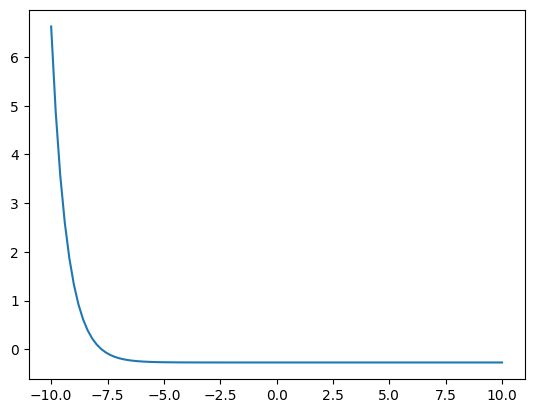

(x0 * -0.6504192937898114 + 2.179148409250277) * (x0 * -1.1333304846869172 + 3.969712184866065)


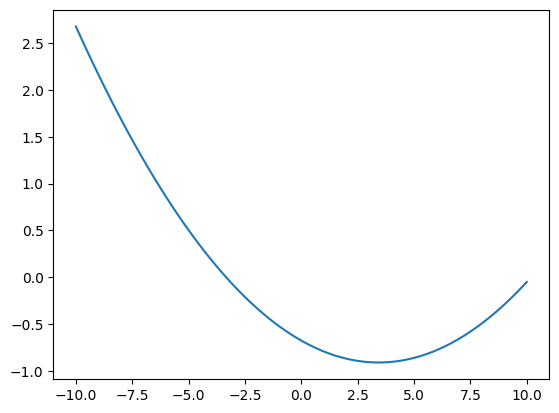

sqrt(x0 * 2.645445730333429 + 3.906307171146505) * -1.3302996656508883 + -0.8988841619618047


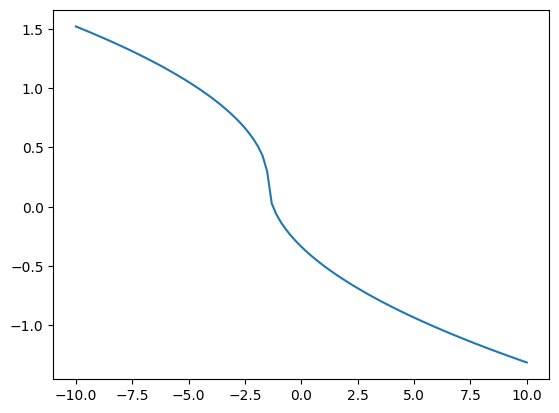

torch.Size([3, 100, 2])
torch.Size([3, 7])


(tensor([[[-1.0000e+01,  6.6271e+00],
          [-9.7980e+00,  4.8761e+00],
          [-9.5959e+00,  3.5695e+00],
          [-9.3939e+00,  2.5945e+00],
          [-9.1919e+00,  1.8670e+00],
          [-8.9899e+00,  1.3241e+00],
          [-8.7879e+00,  9.1904e-01],
          [-8.5858e+00,  6.1679e-01],
          [-8.3838e+00,  3.9125e-01],
          [-8.1818e+00,  2.2295e-01],
          [-7.9798e+00,  9.7374e-02],
          [-7.7778e+00,  3.6697e-03],
          [-7.5757e+00, -6.6251e-02],
          [-7.3737e+00, -1.1842e-01],
          [-7.1717e+00, -1.5736e-01],
          [-6.9697e+00, -1.8641e-01],
          [-6.7677e+00, -2.0808e-01],
          [-6.5656e+00, -2.2426e-01],
          [-6.3636e+00, -2.3633e-01],
          [-6.1616e+00, -2.4533e-01],
          [-5.9596e+00, -2.5205e-01],
          [-5.7576e+00, -2.5707e-01],
          [-5.5555e+00, -2.6081e-01],
          [-5.3535e+00, -2.6360e-01],
          [-5.1515e+00, -2.6568e-01],
          [-4.9495e+00, -2.6724e-01],
          [-

In [10]:
generate_formula_dataset(3,100, 2)

## Training

In [11]:
INPUT_SAMPLES = 100
OUTPUT_FEATURES = 7
THRESHOLD = 0.5
MAX_DEPTH = 3

In [12]:
n_train = 20000
n_test = 1000
train_data, train_labels = generate_formula_dataset(n_train, INPUT_SAMPLES, MAX_DEPTH)
dataset = TensorDataset(train_data, train_labels)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_data, train_labels = generate_formula_dataset(n_test, INPUT_SAMPLES, MAX_DEPTH)
datatest = TensorDataset(test_data, train_labels)
testloader = DataLoader(datatest, batch_size=32, shuffle=True)

[<UnaryOp.EXP: <ufunc 'exp'>>, <UnaryOp.SIN: <ufunc 'sin'>>, <UnaryOp.TAN: <ufunc 'tan'>>, <UnaryOp.ASIN: <ufunc 'arcsin'>>, <UnaryOp.ATAN: <ufunc 'arctan'>>, <UnaryOp.SQRT: <symreg.formula.ExtendedSqrt object at 0x0000016A10F97CB0>>, <UnaryOp.LOG: <symreg.formula.ExtendedLog object at 0x0000016A10F97D70>>] [0.15, 0.2, 0.1, 0.05, 0.1, 0.3, 0.1]
Generated [500]


c:\Users\nboye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:197: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\nboye\AppData\Local\Temp\ipykernel_19380\3039945425.py:62: RuntimeWarning: invalid value encountered in multiply
  Y += eta * np.random.normal(np.mean(Y), np.std(Y), np.shape(Y))
c:\Users\nboye\Documents\projects\MLP-SymReg\symreg\formula.py:360: RuntimeWarning: overflow encountered in exp
  return self.op.value(operand)
c:\Users\nboye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:194: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
c:\Users\nboye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:136: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
c:\Users\nboye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_co

Generated [1000]
Generated [1500]
Generated [2000]
Generated [2500]
Generated [3000]
Generated [3500]
Generated [4000]
Generated [4500]


c:\Users\nboye\Documents\projects\MLP-SymReg\symreg\formula.py:237: RuntimeWarning: overflow encountered in multiply
  return self.op.value(lhs, rhs)


Generated [5000]
Generated [5500]
Generated [6000]
Generated [6500]
Generated [7000]
Generated [7500]
Generated [8000]


c:\Users\nboye\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:208: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Generated [8500]
Generated [9000]
Generated [9500]
Generated [10000]
Generated [10500]
Generated [11000]
Generated [11500]
Generated [12000]
Generated [12500]
Generated [13000]
Generated [13500]
Generated [14000]
Generated [14500]


c:\Users\nboye\Documents\projects\MLP-SymReg\symreg\simplify.py:148: RuntimeWarning: overflow encountered in exp
  return ConstantExpression(expr.op.value(expr.operand.value))


Generated [15000]
Generated [15500]
Generated [16000]
Generated [16500]
Generated [17000]
Generated [17500]
Generated [18000]
Generated [18500]
Generated [19000]
Generated [19500]
Generated [20000]
torch.Size([20000, 100, 2])
torch.Size([20000, 7])
[<UnaryOp.EXP: <ufunc 'exp'>>, <UnaryOp.SIN: <ufunc 'sin'>>, <UnaryOp.TAN: <ufunc 'tan'>>, <UnaryOp.ASIN: <ufunc 'arcsin'>>, <UnaryOp.ATAN: <ufunc 'arctan'>>, <UnaryOp.SQRT: <symreg.formula.ExtendedSqrt object at 0x0000016A10F97CB0>>, <UnaryOp.LOG: <symreg.formula.ExtendedLog object at 0x0000016A10F97D70>>] [0.15, 0.2, 0.1, 0.05, 0.1, 0.3, 0.1]
Generated [500]
Generated [1000]
torch.Size([1000, 100, 2])
torch.Size([1000, 7])


tensor([0., 1., 1., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 1., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 1., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 0., 0., 1.])
tensor([1., 0., 0., 0., 0., 0., 0.])
tensor([1., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 0., 0., 0.])
tensor([0., 0., 0., 0., 0., 1., 0.])
tensor([0., 0., 0., 0., 1., 1., 0.])
tensor([0., 0., 0., 0., 1., 1., 0.])
tensor([0., 1., 0., 0., 1., 0., 1.])
tensor([0., 0., 1., 0., 0., 0., 0.])
tensor([1., 1., 0., 0., 0., 1., 0.])
tensor([0., 1., 0., 0., 0., 0., 1.])
tensor([0., 0., 0., 0., 0., 0., 0.])
tensor([0., 1., 1., 0., 0., 0., 0.])
tensor([0., 1., 0., 0., 1., 1., 0.])


C:\Users\nboye\AppData\Local\Temp\ipykernel_19380\3809423843.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  f.show()


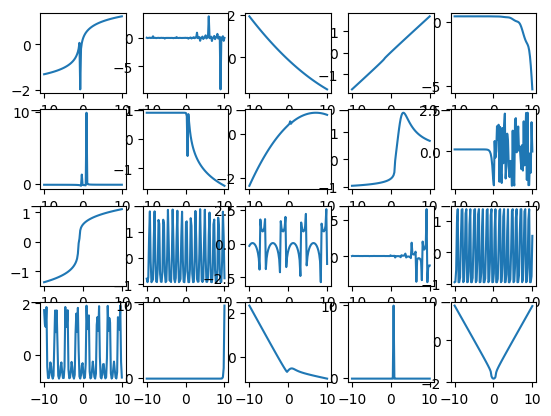

In [13]:
WIDTH, HEIGHT = 5, 4
f, ax = plt.subplots(HEIGHT, WIDTH)
for i in range(HEIGHT):
    for j in range(WIDTH):
        idx = j * HEIGHT + i
        ax[i][j].plot(train_data[idx,:,0], train_data[idx,:,1])
        print(train_labels[idx])
f.show()

In [64]:
def train_model(model, dataloader, epochs, epoch_start=1):
  model.to(device)
  model.train()

  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  loss_fn = nn.MSELoss()

  for epoch in range(epochs):
    running_loss, running_acc = 0.0, 0
    i=0
    nans = 0
    local_n_train = n_train
    for _, data in enumerate(dataloader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = loss_fn(outputs, labels)
      if torch.isnan(loss):
        local_n_train-=len(inputs)
        nans += 1
        i+=1
        continue
      loss.backward()
      optimizer.step()

      preds = (outputs >= THRESHOLD)
      running_acc += torch.sum(preds == labels).item()
      running_loss += loss.item()
      i+=1

      if torch.isnan(outputs[0][0]):print("Un output est nan")

    print(f"[TRAIN epoch {epoch+epoch_start}]: Loss: {running_loss/local_n_train} Accuracy: {running_acc/local_n_train/OUTPUT_FEATURES}, NANs dodged: {nans}")

In [15]:
def test_model(model, dataloader):
  model.to(device)
  model.eval()

  local_n_train = n_test

  running_acc = 0.0
  with torch.no_grad():
    for _, data in enumerate(dataloader):
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = model(inputs)

      preds = (outputs >= THRESHOLD)
      running_acc += torch.sum(preds == labels).item()

  if local_n_train==0:print("Plus rien ne va")

  print(f"[TEST]: Accuracy: {running_acc/local_n_train/OUTPUT_FEATURES}")

In [65]:
class CNN(nn.Module):
    def __init__(self, input_samples, output_features):
        super(CNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=4)  # Pooling after conv1
        
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=4)  # Pooling after conv2
        
        # Fully connected layers
        self.fc1 = nn.Linear(32 * (input_samples // 16), 128)  # Adjust based on pooling output
        self.fc2 = nn.Linear(128, output_features)
        
    def forward(self, x):
        x = x.transpose(1, 2)
        
        # Convolutional layers + activation + pooling
        x = F.relu(self.conv1(x))  # Apply ReLU after conv1
        x = self.pool1(self.relu1(x))          # Apply max pooling after conv1
        
        x = F.relu(self.conv2(x))  # Apply ReLU after conv2
        x = self.pool2(self.relu2(x))          # Apply max pooling after conv2
        
        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)  # Flatten
        
        # Fully connected layers + activation
        x = F.relu(self.fc1(x))    # Apply ReLU after fc1
        x = self.fc2(x)            # Output layer (no activation for regression or classification)
        
        return x

In [ ]:
model = CNN(INPUT_SAMPLES,OUTPUT_FEATURES)

In [70]:
print(sum(p.numel() for p in model.parameters()))
test_model(model, testloader)
for i in range(10):
    train_model(model, dataloader, 5, i*5+1)
    test_model(model, testloader)

27287
[TEST]: Accuracy: 0.9102857142857143
[TRAIN epoch 1]: Loss: 0.0021576123241335153 Accuracy: 0.9103071428571429, NANs dodged: 0
[TRAIN epoch 2]: Loss: 0.0021471371721476316 Accuracy: 0.9105642857142857, NANs dodged: 0
[TRAIN epoch 3]: Loss: 0.002123554767295718 Accuracy: 0.91175, NANs dodged: 0
[TRAIN epoch 4]: Loss: 0.002107831230573356 Accuracy: 0.9129285714285714, NANs dodged: 0
[TRAIN epoch 5]: Loss: 0.0020981072099879386 Accuracy: 0.9129928571428572, NANs dodged: 0
[TEST]: Accuracy: 0.9132857142857143
[TRAIN epoch 6]: Loss: 0.0020857174558565022 Accuracy: 0.9136571428571428, NANs dodged: 0
[TRAIN epoch 7]: Loss: 0.0020679800827987493 Accuracy: 0.9143714285714285, NANs dodged: 0
[TRAIN epoch 8]: Loss: 0.0020576974668540062 Accuracy: 0.9150285714285714, NANs dodged: 0
[TRAIN epoch 9]: Loss: 0.002050073982961476 Accuracy: 0.9156928571428571, NANs dodged: 0
[TRAIN epoch 10]: Loss: 0.002035553330555558 Accuracy: 0.916, NANs dodged: 0
[TEST]: Accuracy: 0.9152857142857143
[TRAIN epo

In [73]:
torch.save(model,"CNN.model")

In [ ]:
model = torch.load("CNN.model")

In [54]:
print(model)

CNN(
  (conv1): Conv1d(2, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=800, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=7, bias=True)
)


In [18]:
def predict(formula):
    X = np.linspace(-10, 10, INPUT_SAMPLES)
    visitor = VectorVisitor()
    visitor.accept(formula.expr)
    Y = formula(X)
    print(Y[0])
    X_norm, Y_norm = normalize(X, Y, INPUT_SAMPLES)
    Y_norm = torch.tensor(np.array([X_norm,Y_norm]).T, dtype=torch.float32).unsqueeze(0)
    preds = model(Y_norm)
    return preds / np.sqrt(np.sum((preds.detach().numpy())**2))

In [19]:
print("EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG")

print(predict(Formula(UnaryExpression(UnaryOp.SIN, VariableExpression(0)))))
print(predict(Formula(UnaryExpression(UnaryOp.LOG, VariableExpression(0)))))
print(predict(Formula(UnaryExpression(UnaryOp.EXP, VariableExpression(0)))))
print(predict(Formula(UnaryExpression(UnaryOp.SQRT, VariableExpression(0)))))

EXP | SIN | TAN | ASIN | ATAN | SQRT | LOG
0.5440211108893698
tensor([[1.3399e-01, 8.8665e-01, 6.7701e-02, 4.3883e-04, 2.5144e-01, 3.4513e-01,
         9.4769e-02]], grad_fn=<DivBackward0>)
-2.302585092994046
tensor([[1.5296e-01, 1.3911e-01, 1.2640e-01, 2.7594e-04, 1.8972e-01, 8.9425e-01,
         3.2495e-01]], grad_fn=<DivBackward0>)
4.5399929762484854e-05
tensor([[0.9158, 0.0486, 0.0072, 0.0027, 0.1068, 0.3787, 0.0637]],
       grad_fn=<DivBackward0>)
-3.1622776601683795
tensor([[ 0.1629,  0.0847,  0.0195, -0.0012,  0.2461,  0.9093,  0.2801]],
       grad_fn=<DivBackward0>)


sqrt(atan(x0 * -1.388724606616476 + 4.090323207429433) * -4.794796830827105 + 0.2944215960779122) * -0.2872735894639842 + 1.372324079768159
[0. 0. 0. 0. 1. 1. 0.]
tensor([[ 3.2618e-01,  2.5039e-01,  7.9844e-03, -1.1283e-04,  4.8190e-01,
          7.1211e-01,  3.0253e-01]], grad_fn=<DivBackward0>)
tensor([[False, False, False, False, False,  True, False]])
0.8571428571428571


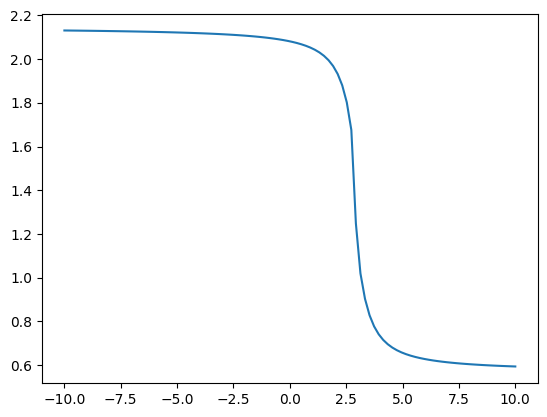

In [21]:
import torch.types

X = np.linspace(-10, 10, INPUT_SAMPLES)
options = RandomOptions()
options.max_depth = 2
options.definition_set = X

formula = random_formula(options)
visitor = VectorVisitor()
visitor.accept(formula.expr)
print(formula)
print(visitor.vector[2:])

Y = formula(X)

X_norm, Y_norm = normalize(X, Y, INPUT_SAMPLES)
Y_norm = torch.tensor(np.array([X_norm,Y_norm]).T, dtype=torch.float32).unsqueeze(0)
preds = model(Y_norm)
print( preds / np.sqrt(np.sum((preds.detach().numpy())**2)) )

preds = model(Y_norm) >= THRESHOLD
print(preds)
print(np.sum(preds.detach().numpy() == visitor.vector[2:]) / OUTPUT_FEATURES)

plt.plot(X, Y)
plt.show()

In [89]:
#target_formula = Formula(UnaryExpression(UnaryOp.LOG, VariableExpression(0) + 11))

X = np.linspace(-10, 10, INPUT_SAMPLES)

from symreg.generator import *
nb_generated = 200
nb_formulas = 200

def predict(target_x, target_y):
    has_nan_or_inf = np.isnan(target_y).any() or np.isinf(target_y).any()
    if has_nan_or_inf:
        print("aie coup dur")
        return torch.tensor([1,1,1,1,1,1,1,1]) / 7
    X_norm, Y_norm = normalize(target_x, target_y, 100)
    Y_norm = torch.tensor(np.array([X_norm,Y_norm]).T, dtype=torch.float32).unsqueeze(0)
    preds = model(Y_norm)
    preds = torch.max(preds,0.05*torch.ones(preds.shape))
    return F.softmax(preds)

def loss_compare(generated_formula, target_formula):
    if np.log(np.sqrt(np.sum((generated_formula(X) - target_formula(X))**2)) / np.sqrt(len(X)) + 1 ) > 90:
        return 0
    return np.log(np.sqrt(np.sum((generated_formula(X) - target_formula(X))**2)) / np.sqrt(len(X)) + 1 )

for _ in range(nb_formulas):
    
    target_formula = random_formula(options)
    random_options = RandomOptions()
    random_options.definition_set = X
    random_options.max_depth = 3

    random_options.prob_unary_operators = np.array([1,1,1,1,1,1,1,1]) / 7
    generator = RandomGenerator(random_options)


    S_rd = []
    for i in range(nb_generated):
        generated_formula = generator.generate()
        try:
            S_rd.append( loss_compare(generated_formula, target_formula) )
        except MathError:
            print("Lalalala")
    proba_unary = predict(X, target_formula(X))
    #uncomment the following to have perfect prediction
    """
    visitor = VectorVisitor()
    visitor.accept(formula.expr)
    proba_unary = F.softmax(torch.tensor(visitor.vector[2:]))
    """
    random_options.prob_unary_operators = proba_unary.flatten().detach().numpy()
    generator = RandomGenerator(random_options)

    S_CNN = []
    for i in range(nb_generated):
        generated_formula = generator.generate()
        #plt.plot(X, generated_formula(X))
        try:
            S_CNN.append( loss_compare(generated_formula, target_formula) )
        except MathError:
            print("Lalala2")

print(f"Loss avec Random : {np.mean(S_rd)} std {np.std(S_rd)/np.sqrt(len(S_rd))}")
print(f"Loss avec CNN : {np.mean(S_CNN)} std {np.std(S_CNN)/np.sqrt(len(S_CNN))}")

C:\Users\nboye\AppData\Local\Temp\ipykernel_19380\3112278235.py:18: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(preds)
C:\Users\nboye\AppData\Local\Temp\ipykernel_19380\3112278235.py:21: RuntimeWarning: overflow encountered in square
  if np.log(np.sqrt(np.sum((generated_formula(X) - target_formula(X))**2)) / np.sqrt(len(X)) + 1 ) > 90:


aie coup dur
Loss avec Random : 6.277365818246892 std 0.5110012073940454
Loss avec CNN : 6.266515608399614 std 0.5596748472571781


##### np.exp(1900) == np.inf